In [1]:
import sys
import functools
from collections import namedtuple
import numpy as np
from uncertainties import ufloat, unumpy
import uncertainties
import scipy
import matplotlib
import matplotlib.pyplot as plt
import mplhep as hep
plt.style.use(hep.style.CMS)

sys.path.append("..")

%load_ext autoreload
%autoreload 1
from ntupleReaders.clue_ntuple_reader import ClueNtupleReader
from hists.parameters import beamEnergies, synchrotronBeamEnergiesMap
%aimport energy_resolution.sigma_over_e
from energy_resolution.sigma_over_e import SigmaOverEComputations, fitSigmaOverE, SigmaOverEPlotElement, plotSigmaOverMean, sigmaOverE_fitFunction, plotSCAsEllipse, EResolutionFitResult, SigmaMuResult, plotEllipse, plotFittedMean
from energy_resolution.hist_loader import HistLoader
#from fit import HistogramEstimates

In [2]:
levels = ["rechits", "clue", "clue3d"]
levelLabelMap = {"rechits":"Rechits", "clue":"CLUE", "clue3d":"CLUE3D", "paper" : "JINST paper"}
levelColorMap = {"rechits":"tab:blue", "clue":"tab:orange", "clue3d":"tab:green"}

In [3]:
reader_data = ClueNtupleReader("v41", "cmssw", "data") 
reader_sim = ClueNtupleReader("v41", "cmssw", "sim_proton_v46_patchMIP") 
comp_data = SigmaOverEComputations(sigmaWindow=(1, 2.5))
res_data = {level : comp_data.compute({beamEnergy : HistLoader(reader_data.histStore).getProjected(reader_data.datatype, beamEnergy, level) for beamEnergy in beamEnergies}, multiprocess=True)
            for level in levels}
comp_sim = SigmaOverEComputations(sigmaWindow=(1, 2.5))
res_sim = {level : comp_sim.compute({beamEnergy : HistLoader(reader_sim.histStore).getProjected(reader_sim.datatype, beamEnergy, level) for beamEnergy in beamEnergies}, multiprocess=True)
            for level in levels}

2023-06-29 17:57:15.572732: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:1278] could not retrieve CUDA device count: CUDA_ERROR_NOT_INITIALIZED: initialization error
2023-06-29 17:57:15.572736: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:1278] could not retrieve CUDA device count: CUDA_ERROR_NOT_INITIALIZED: initialization error
2023-06-29 17:57:15.572762: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:1278] could not retrieve CUDA device count: CUDA_ERROR_NOT_INITIALIZED: initialization error
2023-06-29 17:57:15.573008: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:1278] could not retrieve CUDA device count: CUDA_ERROR_NOT_INITIALIZED: initialization error
2023-06-29 17:57:15.574204: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:1278] could not retrieve CUDA device count: CUDA_ERROR_NOT_INITIALIZED: initialization error
2023-06-29 17:57:15.574428: E tensorflow/compiler/xla/stream_executor/cuda/cuda_drive

In [4]:
res_data["rechits"][20]

SigmaMuResult(mu=19.640632104278215+/-0.012204959165682169, sigma=0.9521271985973383+/-0.010711188164569934, fitResult=<zfit.minimizers.fitresult.FitResult object at 0x7f1c0708ebf0>, fitQuality='good')

In [5]:
eRes_fit_data = {level : fitSigmaOverE(res) for level, res in res_data.items()}
eRes_fit_sim = {level : fitSigmaOverE(res) for level, res in res_sim.items()}

# From JINST paper (https://arxiv.org/abs/2111.06855), table 3, dEdx method
paperResolution_data = EResolutionFitResult(S=uncertainties.ufloat(22, 0.3)/100, C=uncertainties.ufloat(0.53, 0.09)/100)
paperResolution_sim = EResolutionFitResult(S=uncertainties.ufloat(21.3, 0.3)/100, C=uncertainties.ufloat(0.55, 0.07)/100)

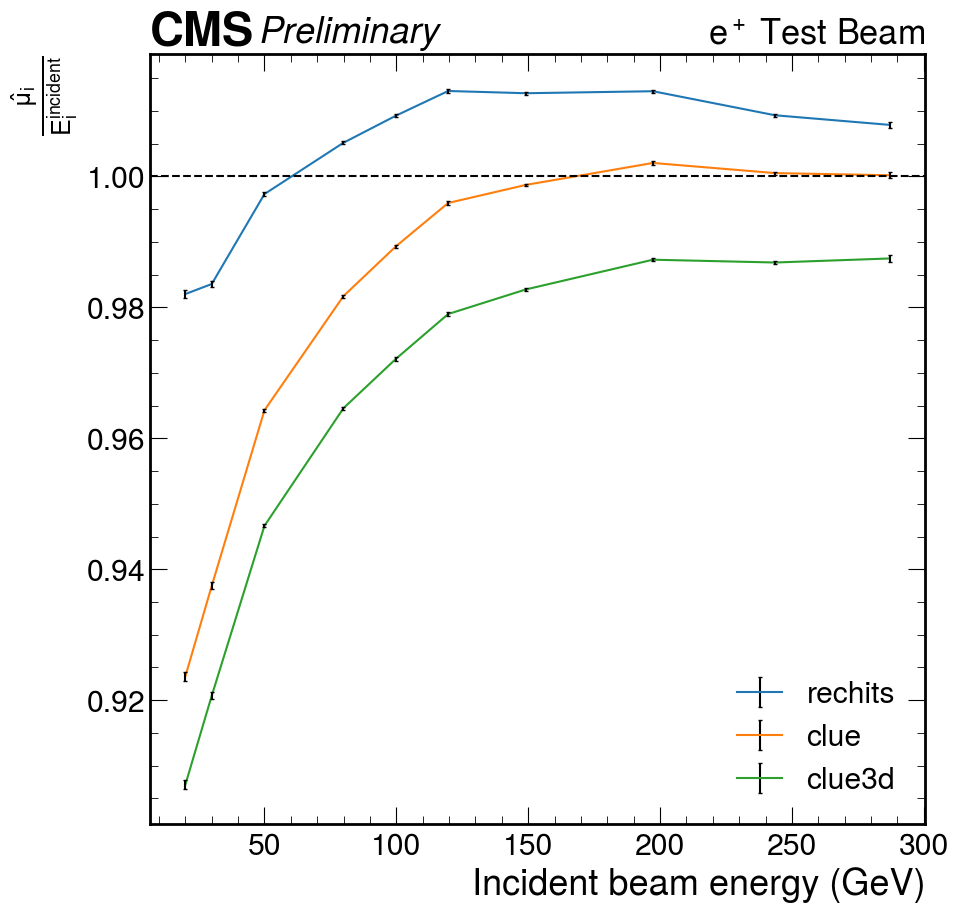

In [6]:
plotFittedMean(res_data, errors=True)
plt.savefig("plots/mu-over-beam.pdf", bbox_inches="tight")

In [18]:
def makeDataPoints(res:dict[int, SigmaMuResult]):
    return {beamEnergy : result.sigma / result.mu for beamEnergy, result in res.items()}

def plotFctOfE(res, eRes_fit, showClue=True, **kwargs):
    plotElements = [
        SigmaOverEPlotElement("Rechits", fitResult=eRes_fit_data["rechits"], fitFunction=sigmaOverE_fitFunction, 
            dataPoints=makeDataPoints(res_data["rechits"]), color=levelColorMap["rechits"]),
        SigmaOverEPlotElement("CLUE3D", fitResult=eRes_fit_data["clue3d"], fitFunction=sigmaOverE_fitFunction, 
            dataPoints=makeDataPoints(res_data["clue3d"]), color=levelColorMap["clue3d"]),
    ]
    if showClue:
        plotElements.insert(1, SigmaOverEPlotElement("CLUE", fitResult=eRes_fit_data["clue"], fitFunction=sigmaOverE_fitFunction, 
            dataPoints=makeDataPoints(res_data["clue"]), color=levelColorMap["clue"]))
    plotSigmaOverMean(plotElements=plotElements, **kwargs)

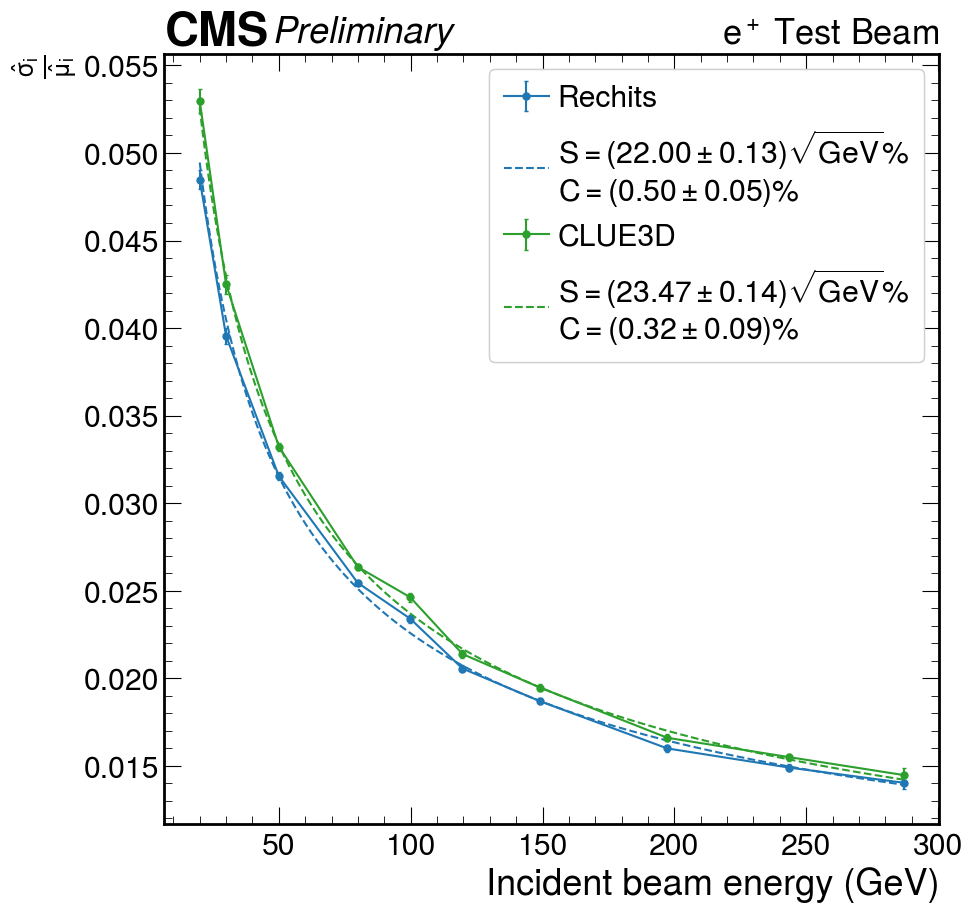

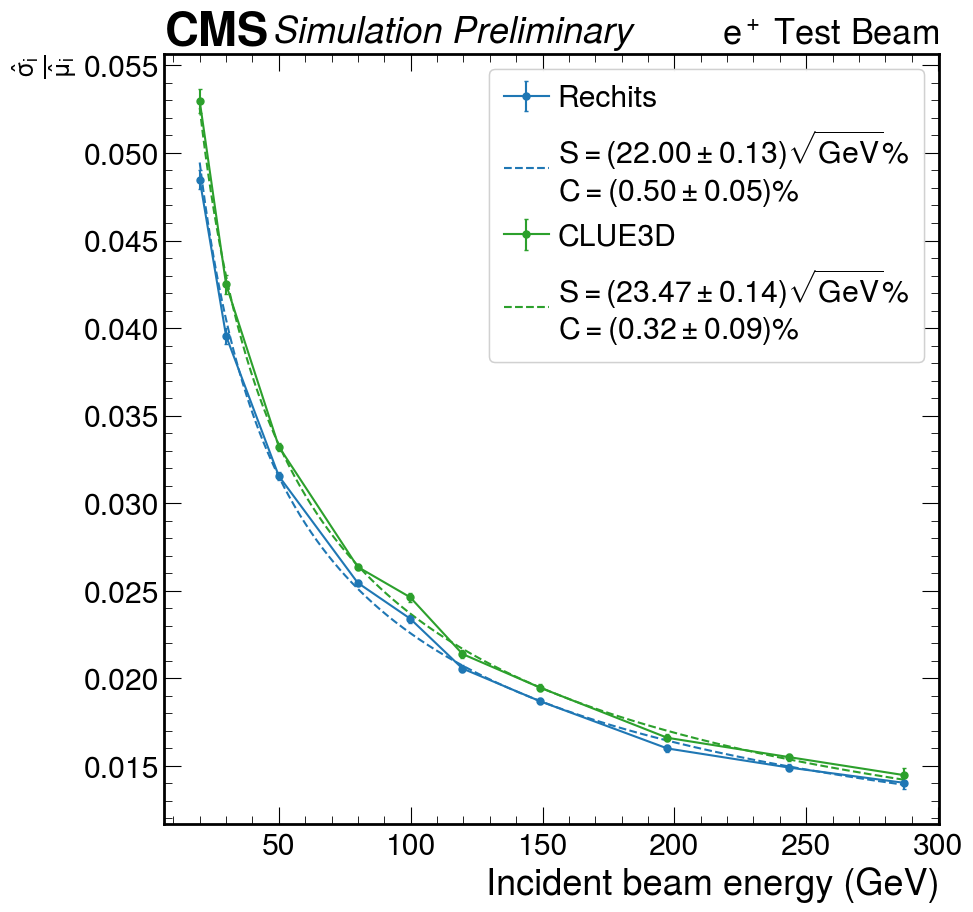

In [20]:
plotFctOfE(res_data, eRes_fit_data, showClue=False, plotFit=True)
plt.savefig("plots/sigmaOverE/fctOfE-data.pdf", bbox_inches="tight")
plotFctOfE(res_sim, eRes_fit_sim, showClue=False, sim=True, plotFit=True)
plt.savefig("plots/sigmaOverE/fctOfE-sim.pdf", bbox_inches="tight")

In [9]:
def plotFctOfSqrtE(res, eRes_fit, **kwargs):
    # fig = plt.figure()
    # grid = fig.add_gridspec(2, 1, hspace=0, height_ratios=[3, 1])
    # main_ax = fig.add_subplot(grid[0])
    # subplot_ax = fig.add_subplot(grid[1], sharex=main_ax)
    # plt.setp(main_ax.get_xticklabels(), visible=False)
    
    plotSigmaOverMean(plotElements=[
        SigmaOverEPlotElement("Rechits", fitResult=eRes_fit["rechits"], fitFunction=sigmaOverE_fitFunction, 
            dataPoints=makeDataPoints(res["rechits"]), color=levelColorMap["rechits"], legendGroup=0),
        # SigmaOverEPlotElement("CLUE", fitResult=eRes_fit["clue"], fitFunction=sigmaOverE_fitFunction, 
        #     dataPoints=makeDataPoints(res["clue"]), color=levelColorMap["clue"], legendGroup=1),
        SigmaOverEPlotElement("CLUE3D", fitResult=eRes_fit["clue3d"], fitFunction=sigmaOverE_fitFunction, 
            dataPoints=makeDataPoints(res["clue3d"]), color=levelColorMap["clue3d"], legendGroup=0),
        
    ], xMode="1/sqrt(E)", plotFit=True)
    plt.annotate(r"Fitting $\frac{\hat{\sigma}_i}{\hat{\mu}_i} = \frac{S}{\sqrt{E_i^{incident}}} \oplus C$", (0.06, 0.035))

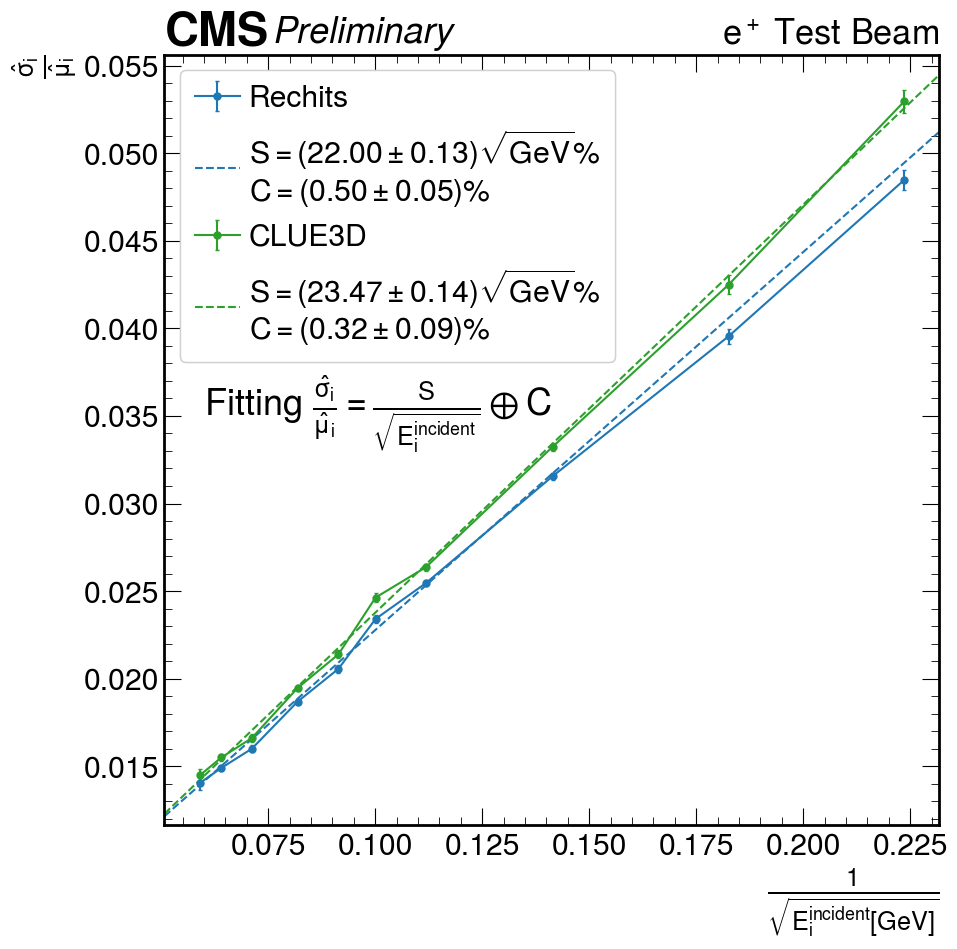

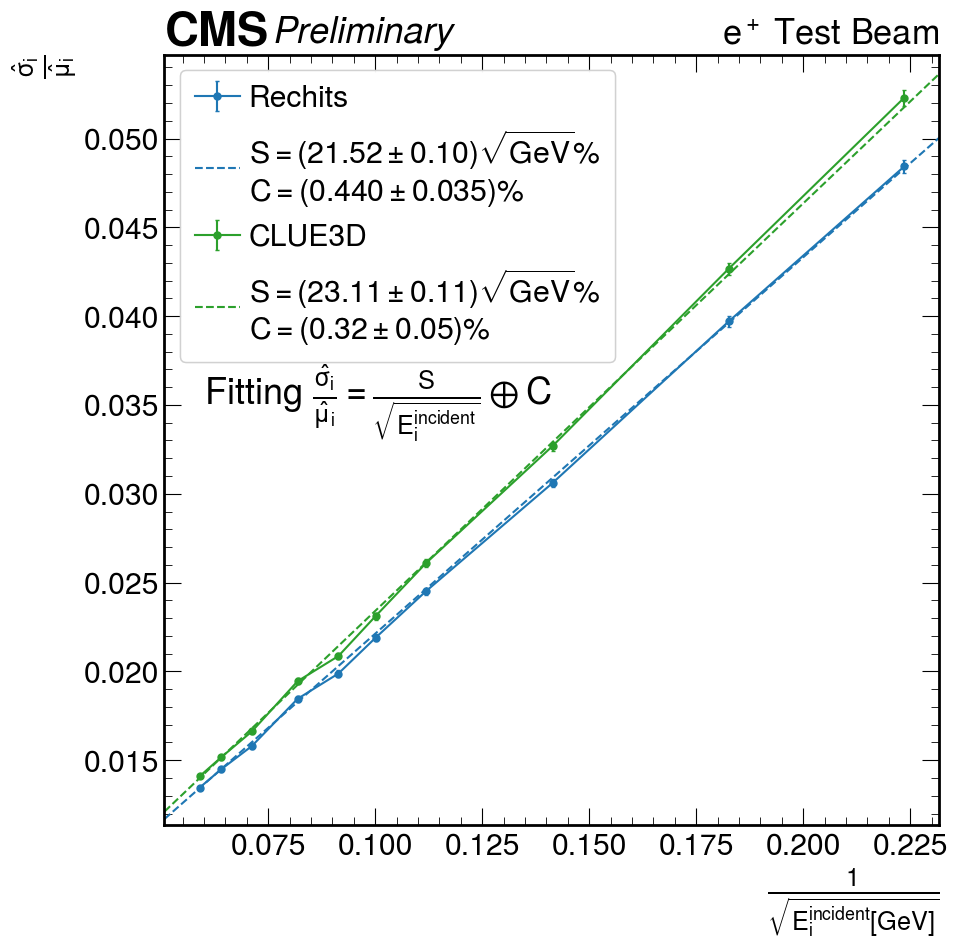

In [10]:
plotFctOfSqrtE(res_data, eRes_fit_data, xMode="1/sqrt(E)")
plt.savefig("plots/sigmaOverE/fctOfSqrtE-data.pdf", bbox_inches="tight")
plotFctOfSqrtE(res_sim, eRes_fit_sim, sim=True, xMode="1/sqrt(E)")
plt.savefig("plots/sigmaOverE/fctOfSqrtE-sim.pdf", bbox_inches="tight")

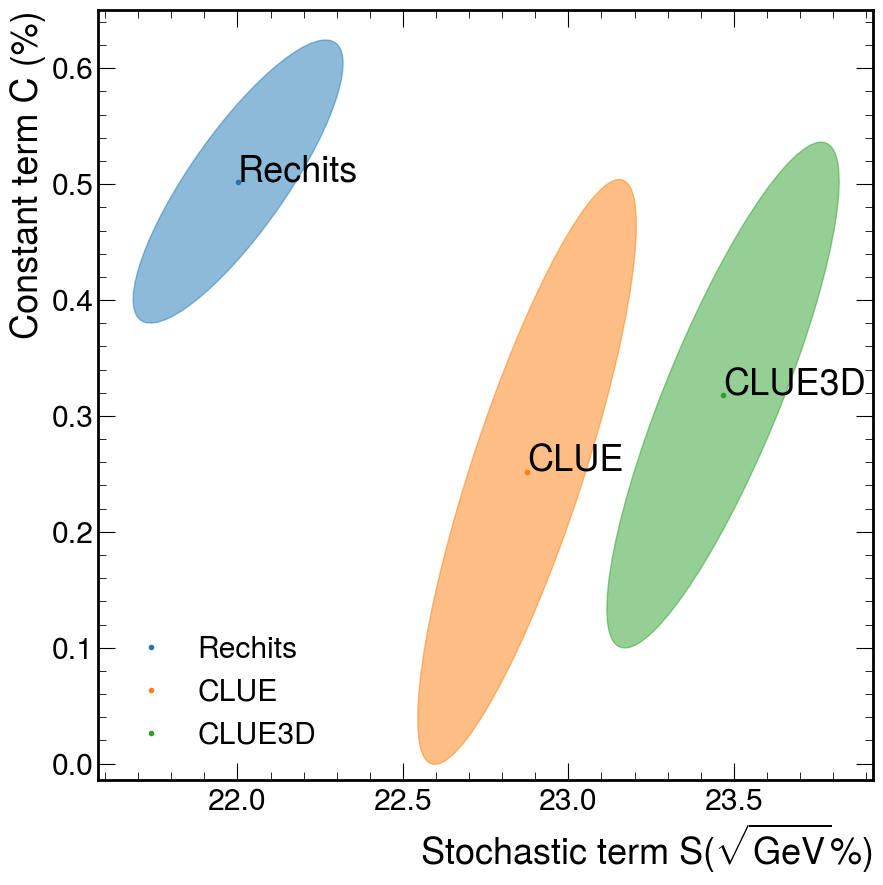

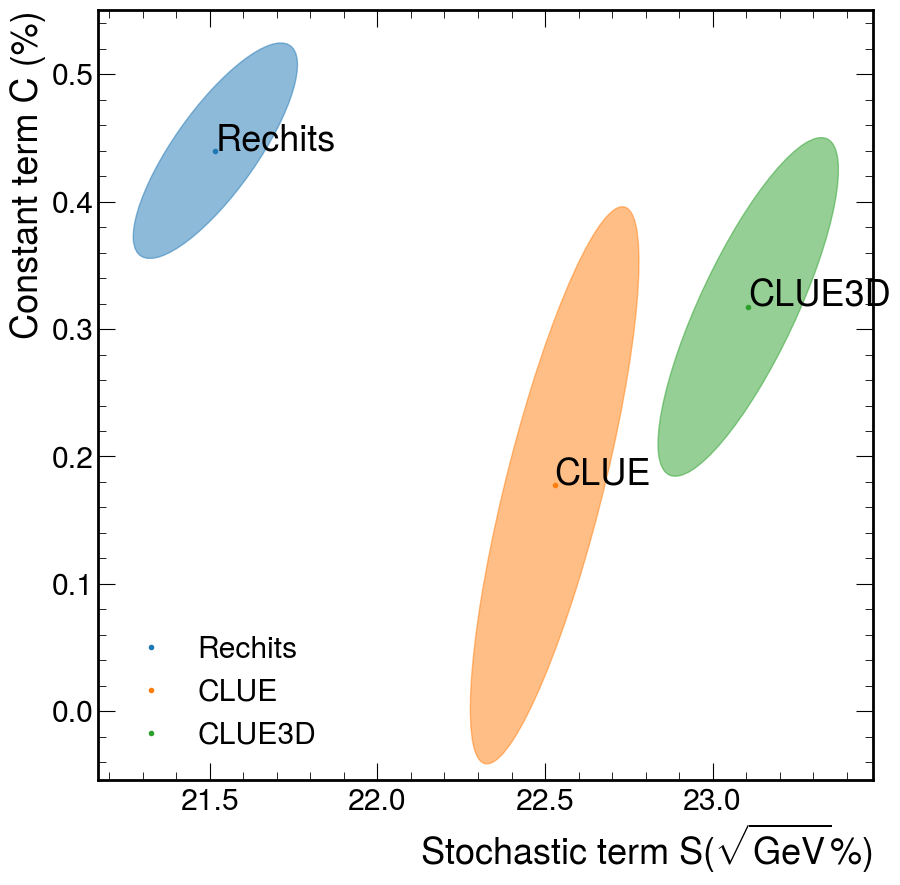

In [11]:
def plotEllipseForDatatype(res, eRes_fit, **kwargs):
    plotSCAsEllipse([
            SigmaOverEPlotElement("Rechits", fitResult=eRes_fit["rechits"], fitFunction=sigmaOverE_fitFunction, 
                dataPoints=makeDataPoints(res["rechits"]), color=levelColorMap["rechits"], legendGroup=0),
            SigmaOverEPlotElement("CLUE", fitResult=eRes_fit["clue"], fitFunction=sigmaOverE_fitFunction, 
                dataPoints=makeDataPoints(res["clue"]), color=levelColorMap["clue"], legendGroup=1),
            SigmaOverEPlotElement("CLUE3D", fitResult=eRes_fit["clue3d"], fitFunction=sigmaOverE_fitFunction, 
                dataPoints=makeDataPoints(res["clue3d"]), color=levelColorMap["clue3d"], legendGroup=0)
        ],
        detailedLabels=True
    )
plotEllipseForDatatype(res_data, eRes_fit_data)
plotEllipseForDatatype(res_sim, eRes_fit_sim)

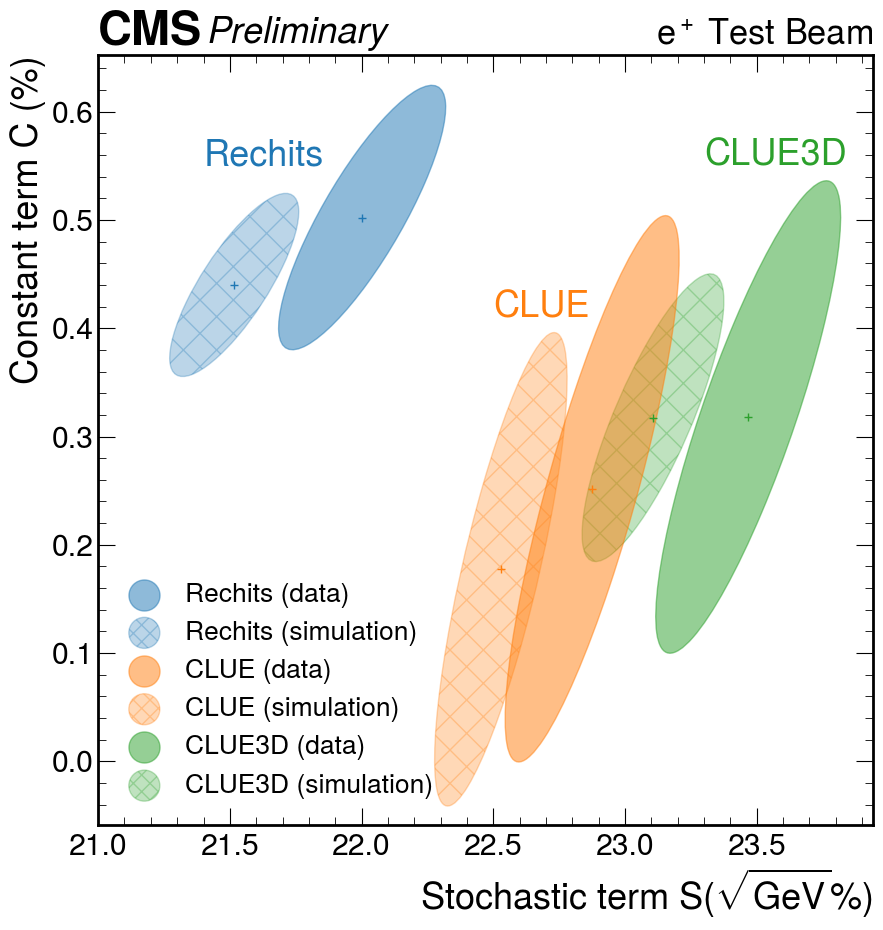

In [12]:
plotElts_data = [
    SigmaOverEPlotElement("Rechits (data)", fitResult=eRes_fit_data["rechits"], fitFunction=sigmaOverE_fitFunction, 
        dataPoints=makeDataPoints(res_data["rechits"]), color=levelColorMap["rechits"], legendGroup=0),
    SigmaOverEPlotElement("CLUE (data)", fitResult=eRes_fit_data["clue"], fitFunction=sigmaOverE_fitFunction, 
        dataPoints=makeDataPoints(res_data["clue"]), color=levelColorMap["clue"], legendGroup=1),
    SigmaOverEPlotElement("CLUE3D (data)", fitResult=eRes_fit_data["clue3d"], fitFunction=sigmaOverE_fitFunction, 
        dataPoints=makeDataPoints(res_data["clue3d"]), color=levelColorMap["clue3d"], legendGroup=0),
]
plotElts_sim = [
    SigmaOverEPlotElement("Rechits (simulation)", fitResult=eRes_fit_sim["rechits"], fitFunction=sigmaOverE_fitFunction, 
        dataPoints=makeDataPoints(res_sim["rechits"]), color=levelColorMap["rechits"], legendGroup=0),
    SigmaOverEPlotElement("CLUE (simulation)", fitResult=eRes_fit_sim["clue"], fitFunction=sigmaOverE_fitFunction, 
        dataPoints=makeDataPoints(res_sim["clue"]), color=levelColorMap["clue"], legendGroup=1),
    SigmaOverEPlotElement("CLUE3D (simulation)", fitResult=eRes_fit_sim["clue3d"], fitFunction=sigmaOverE_fitFunction, 
        dataPoints=makeDataPoints(res_sim["clue3d"]), color=levelColorMap["clue3d"], legendGroup=0)
]
fig, ax = plt.subplots()
def plotEllipseFromPlotElts(plotElement:SigmaOverEPlotElement, sim=False, **ellipse_kwargs):
    S_scaled, C_scaled = plotElement.fitResult.S*100, plotElement.fitResult.C*100
    x, y = S_scaled.nominal_value, C_scaled.nominal_value
    label = None if sim else plotElement.legend
    ax.plot([x], [y], "+", label=label, color=plotElement.color)
    ax.add_patch(plotEllipse(S_scaled, C_scaled, ellipse_kwargs=dict(color=plotElement.color, alpha=0.5)|ellipse_kwargs))
    if not sim:
        #ax.annotate(plotElement.legend, xy=(x, y))
        pass

legend_handle_bound = functools.partial(plt.scatter, [], [], s=500, marker='o', alpha=0.5,)
legend_handles = []
for plotElement_data, plotElement_sim in zip(plotElts_data, plotElts_sim):
    plotEllipseFromPlotElts(plotElement_data)
    legend_handles.append(legend_handle_bound(label=plotElement_data.legend, color=plotElement_data.color))
    plotEllipseFromPlotElts(plotElement_sim, sim=True, hatch="x", alpha=0.3, zorder=-1)
    legend_handles.append(legend_handle_bound(label=plotElement_sim.legend, color=plotElement_sim.color, alpha=0.3,  hatch="xx"))

hep.cms.text("Preliminary", ax=ax)
hep.cms.lumitext(f"$e^+$ Test Beam", ax=ax)
ax.set_xlabel(r"Stochastic term $S (\sqrt{GeV} \%)$")
ax.set_ylabel(r"Constant term C (%)")
ax.set_xlim(left=21)

ax.legend(handles=legend_handles, prop={'size': 19})
ax.annotate("Rechits", (21.4, 0.55), color="tab:blue")
ax.annotate("CLUE", (22.5, 0.41), color="tab:orange")
ax.annotate("CLUE3D", (23.3, 0.55), color="tab:green")
plt.savefig("plots/energy-resolution-ellipses.png", bbox_inches="tight", dpi=200) # for some reasons hatches don't work in pdf

In [13]:
matplotlib.rcParams["figure.dpi"]

100.0